## 🎯 Objectif du notebook

Ce notebook vise à **structurer les données nettoyées** (Silver) selon un **modèle en étoile**, dans le but d'alimenter Power BI efficacement.  
Les objectifs sont les suivants :
- Charger les données depuis la zone Silver,
- Supprimer les doublons et finaliser les noms de colonnes,
- Construire des **tables de dimensions** (Pays, Maladie, Démographie),
- Créer une **table de faits** `fact_health`,
- Enregistrer ces tables en base pour la zone Gold,
- Réaliser une **analyse exploratoire** via des statistiques descriptives et une matrice de corrélation.


In [2]:
# Lecture du dataset Silver
df_silver = spark.read.format("delta").load("Files/silver/global_health_clean")

# Afficher les colonnes et types
df_silver.printSchema()

# Aperçu
display(df_silver.limit(5))

# Nombre de lignes
print(f"Nombre de lignes : {df_silver.count()}")


StatementMeta(, 310f61ff-dc79-451d-acbd-29711eadf53a, 4, Finished, Available, Finished)

root
 |-- country: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- disease_name: string (nullable = true)
 |-- disease_category: string (nullable = true)
 |-- prevalence_rate_: double (nullable = true)
 |-- incidence_rate_: double (nullable = true)
 |-- mortality_rate_: double (nullable = true)
 |-- age_group: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- population_affected: integer (nullable = true)
 |-- healthcare_access_: double (nullable = true)
 |-- doctors_per_1000: double (nullable = true)
 |-- hospital_beds_per_1000: double (nullable = true)
 |-- treatment_type: string (nullable = true)
 |-- average_treatment_cost_usd: integer (nullable = true)
 |-- availability_of_vaccinestreatment: string (nullable = true)
 |-- recovery_rate_: double (nullable = true)
 |-- dalys: integer (nullable = true)
 |-- improvement_in_5_years_: double (nullable = true)
 |-- per_capita_income_usd: integer (nullable = true)
 |-- education_index: double (nullable 

SynapseWidget(Synapse.DataFrame, 8d0a606c-e86a-413f-9e35-ef86c2347d81)

Nombre de lignes : 1000000


In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, regexp_replace, lower, monotonically_increasing_id
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

spark = SparkSession.builder.getOrCreate()

# 1. Chargement des données depuis la table Silver
print(" Lecture de la table silver")
df_silver = spark.read.table("global_health_silver")

# 2. Nettoyage final
df_silver_clean = df_silver.dropDuplicates()

rename_map = {
    col_name: col_name.rstrip("_")
    for col_name in df_silver_clean.columns
    if col_name.endswith("_")
}

for old_name, new_name in rename_map.items():
    df_silver_clean = df_silver_clean.withColumnRenamed(old_name, new_name)

print("✅ Colonnes renommées proprement")
df_silver_clean.printSchema()




StatementMeta(, 310f61ff-dc79-451d-acbd-29711eadf53a, 5, Finished, Available, Finished)

 Lecture de la table silver
✅ Colonnes renommées proprement
root
 |-- country: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- disease_name: string (nullable = true)
 |-- disease_category: string (nullable = true)
 |-- prevalence_rate: double (nullable = true)
 |-- incidence_rate: double (nullable = true)
 |-- mortality_rate: double (nullable = true)
 |-- age_group: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- population_affected: integer (nullable = true)
 |-- healthcare_access: double (nullable = true)
 |-- doctors_per_1000: double (nullable = true)
 |-- hospital_beds_per_1000: double (nullable = true)
 |-- treatment_type: string (nullable = true)
 |-- average_treatment_cost_usd: integer (nullable = true)
 |-- availability_of_vaccinestreatment: string (nullable = true)
 |-- recovery_rate: double (nullable = true)
 |-- dalys: integer (nullable = true)
 |-- improvement_in_5_years: double (nullable = true)
 |-- per_capita_income_usd: integer (nu

In [4]:
# 3. Création des tables de dimensions
print(" Création des dimensions")

# Dim Pays
dim_country = df_silver_clean.select(
    "country",
    "per_capita_income_usd",
    "education_index",
    "urbanization_rate",
    "population_affected"
).dropDuplicates().withColumn("country_id", monotonically_increasing_id())


# Dim Maladie
dim_disease = df_silver_clean.select(
    "disease_name",
    "disease_category",
    "treatment_type",
    "availability_of_vaccinestreatment"
).dropDuplicates().withColumn("disease_id", monotonically_increasing_id())

# Dim Démographie
dim_demographics = df_silver_clean.select(
    "age_group", "gender"
).dropDuplicates().withColumn("demo_id", monotonically_increasing_id())



StatementMeta(, 310f61ff-dc79-451d-acbd-29711eadf53a, 6, Finished, Available, Finished)

 Création des dimensions


StatementMeta(, 310f61ff-dc79-451d-acbd-29711eadf53a, 13, Finished, Available, Finished)

✅ Construction de la table de faits
 Sauvegarde des tables
✅ Modèle en étoile prêt pour Power BI
+-------+------------------+------------------+------------------+------------------+
|summary|   prevalence_rate|    mortality_rate|     recovery_rate|             dalys|
+-------+------------------+------------------+------------------+------------------+
|  count|           1000000|           1000000|           1000000|           1000000|
|   mean|10.047991859999952| 5.049918859999973| 74.49693378999991|       2499.144809|
| stddev| 5.740189345095459|2.8594265292775782|14.155168150475706|1443.9237975652622|
|    min|               0.1|               0.1|              50.0|                 1|
|    max|              20.0|              10.0|              99.0|              5000|
+-------+------------------+------------------+------------------+------------------+



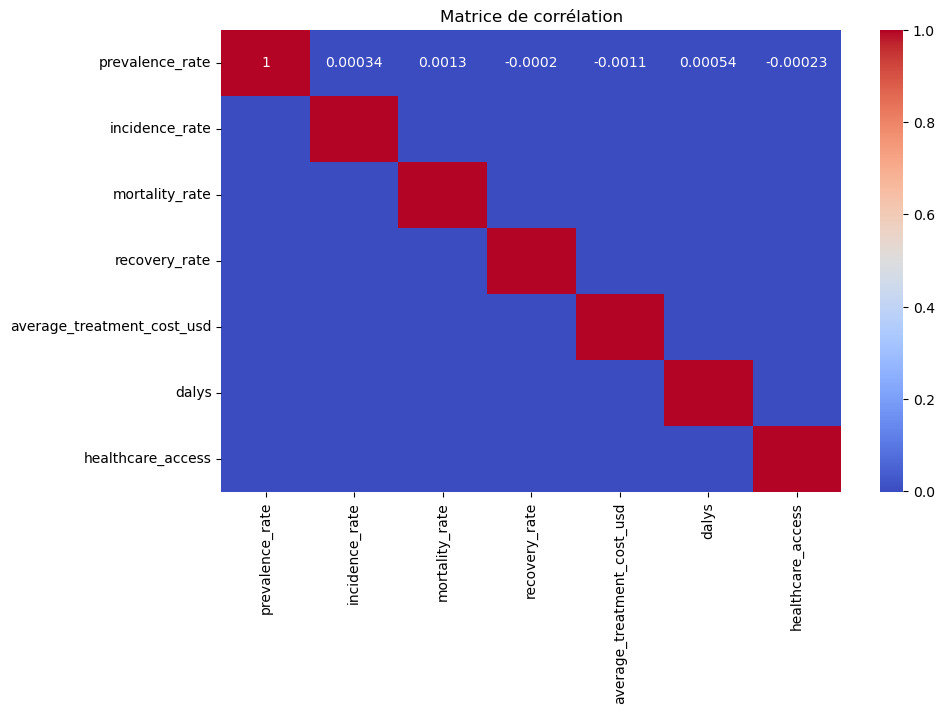

✅ Notebook 2 terminé


In [11]:
# 4. Table de faits
print("✅ Construction de la table de faits")
fact_health = df_silver_clean \
    .join(dim_country, on=["country", "per_capita_income_usd", "education_index", "urbanization_rate","population_affected"]) \
    .join(dim_disease, on=["disease_name", "disease_category", "treatment_type", "availability_of_vaccinestreatment"]) \
    .join(dim_demographics, on=["age_group", "gender"]) \
    .select(
        "country_id", "disease_id", "demo_id", "year",
        "prevalence_rate", "incidence_rate", "mortality_rate", "recovery_rate",
        "average_treatment_cost_usd", "dalys", "healthcare_access"
    )

# 5. Sauvegarde
print(" Sauvegarde des tables")
#dim_country.write.mode("overwrite").saveAsTable("dim_country")
dim_country.write.option("mergeSchema", "true").mode("overwrite").saveAsTable("dim_country")
dim_disease.write.mode("overwrite").saveAsTable("dim_disease")
dim_demographics.write.mode("overwrite").saveAsTable("dim_demo")
#fact_health.write.mode("overwrite").saveAsTable("fact_health")
fact_health.write.option("mergeSchema", "true").mode("overwrite").saveAsTable("fact_health")

print("✅ Modèle en étoile prêt pour Power BI")

# 6. Statistiques descriptives
df_silver_clean.select("prevalence_rate", "mortality_rate", "recovery_rate", "dalys").describe().show()

# 7. Corrélation (EDA)
pdf = df_silver_clean.select(
    "prevalence_rate", "incidence_rate", "mortality_rate", "recovery_rate",
    "average_treatment_cost_usd", "dalys", "healthcare_access"
).toPandas()

plt.figure(figsize=(10,6))
sns.heatmap(pdf.corr(), annot=True, cmap="coolwarm")
plt.title("Matrice de corrélation")
plt.show()

print("✅ Notebook 2 terminé")
